<a href="https://colab.research.google.com/github/josematez/DeepLearning_SkinCancer/blob/main/Testing_Data_Jose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.15.4
!pip install deepdish
#!pip install tensorflow==1.15
#!pip install keras

     |████████████████████████████████| 13.9MB 241kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.15.4 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.1 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from keras.layers.normalization import BatchNormalization

from tensorflow.keras.applications.xception import Xception

In [14]:
np.__version__

'1.15.4'

In [15]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [17]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [18]:
X = np.zeros((10015, 75, 100, 3))

for i in range(10015):
  X[i,:,:,:] = X_raw[i]

In [19]:
print("Tamaño datos X: {}".format(X.shape))
print("Tamaño datos Y: {}".format(Y.shape))

Tamaño datos X: (10015, 75, 100, 3)
Tamaño datos Y: (10015,)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12345)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state = 12345)

In [21]:
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))
X_val = (X_val / np.max(X_val))

In [22]:
Y_train = to_categorical(Y_train, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)
Y_val = to_categorical(Y_val, num_classes = 7)

In [23]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [24]:
input_shape = (75, 100, 3)
num_classes = 7

#Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

model = base_model.output
model = Flatten()(model)

model = Dense(512, kernel_initializer='he_uniform', activation='relu')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = Dense(128, kernel_initializer='he_uniform', activation='relu')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = Dense(64, kernel_initializer='he_uniform', activation='relu')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

model = Dense(16, kernel_initializer='he_uniform', activation='relu')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)

output = Dense(num_classes, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=output)

In [25]:
epocas = 100
bs = 32
lr = 0.0001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.00001)
callbacks = [reduce_lr]

In [26]:
historico = model.fit(datagen.flow(X_train, Y_train, batch_size = bs), epochs = epocas, batch_size = bs, validation_data = (X_val, Y_val), callbacks = callbacks)

Epoch 1/100
201/201 [==============================] - 25s 125ms/step - loss: 2.1999 - accuracy: 0.1832 - val_loss: 1.7598 - val_accuracy: 0.3768
Epoch 2/100
201/201 [==============================] - 24s 121ms/step - loss: 1.8791 - accuracy: 0.2838 - val_loss: 1.4593 - val_accuracy: 0.5315
Epoch 3/100
201/201 [==============================] - 24s 118ms/step - loss: 1.6751 - accuracy: 0.3774 - val_loss: 1.4515 - val_accuracy: 0.5758
Epoch 4/100
201/201 [==============================] - 24s 118ms/step - loss: 1.5351 - accuracy: 0.4601 - val_loss: 1.3782 - val_accuracy: 0.6276
Epoch 5/100
201/201 [==============================] - 24s 119ms/step - loss: 1.4138 - accuracy: 0.5279 - val_loss: 1.1706 - val_accuracy: 0.6831
Epoch 6/100
201/201 [==============================] - 24s 119ms/step - loss: 1.3115 - accuracy: 0.5918 - val_loss: 1.1163 - val_accuracy: 0.6925
Epoch 7/100
201/201 [==============================] - 24s 119ms/step - loss: 1.2250 - accuracy: 0.6241 - val_loss: 1.0730 -

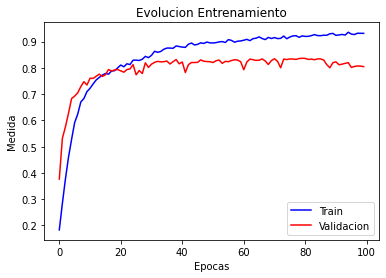

In [27]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

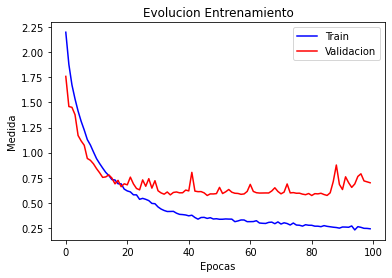

In [28]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [29]:
metricas = model.evaluate(X_test, Y_test)

63/63 [==============================] - 2s 35ms/step - loss: 0.6413 - accuracy: 0.8218
